# Parsing Conventions and standards with Python

Metadata conventions, like the Climate and Forecast (CF) conventions,
can be cumbersome to adhere to but it will be very handy when manipulating the data later.
In this notebook we will explore three Python modules that parse [`CF-1.6`](http://cfconventions.org/cf-conventions/v1.6.0/cf-conventions.html),
[`UGRID-1.0`](http://ugrid-conventions.github.io/ugrid-conventions/),
and [`SGRID=0.3`](http://sgrid.github.io/sgrid/)

### CF-1.6 with iris

There are many Python libraries to read and write CF metdata,
but only [`iris`](http://scitools.org.uk/iris/) encapsulates CF in an object with an API.
From iris own docs:

    Iris seeks to provide a powerful, easy to use, and community-driven Python library for analysing and visualising meteorological and oceanographic data sets.

    With iris you can:

    - Use a single API to work on your data, irrespective of its original format.
    - Read and write (CF-)netCDF, GRIB, and PP files.
    - Easily produce graphs and maps via integration with matplotlib and cartopy.

In [1]:
import iris

iris.FUTURE.netcdf_promote = True

url = ('http://omgsrv1.meas.ncsu.edu:8080/thredds/dodsC/fmrc/'
       'sabgom/SABGOM_Forecast_Model_Run_Collection_best.ncd')

cubes = iris.load(url)

/home/filipe/miniconda3/envs/IOOS/lib/python3.5/site-packages/iris/fileformats/cf.py:1059: UserWarning: Ignoring formula terms variable 'h' referenced by data variable 'v' via variable 's_rho': Dimensions ('eta_rho', 'xi_rho') do not span ('time', 's_rho', 'eta_v', 'xi_v')
  warnings.warn(msg)
/home/filipe/miniconda3/envs/IOOS/lib/python3.5/site-packages/iris/fileformats/cf.py:1059: UserWarning: Ignoring formula terms variable 'zeta' referenced by data variable 'v' via variable 's_rho': Dimensions ('time', 'eta_rho', 'xi_rho') do not span ('time', 's_rho', 'eta_v', 'xi_v')
  warnings.warn(msg)
/home/filipe/miniconda3/envs/IOOS/lib/python3.5/site-packages/iris/fileformats/cf.py:1059: UserWarning: Ignoring formula terms variable 'h' referenced by data variable 'u' via variable 's_rho': Dimensions ('eta_rho', 'xi_rho') do not span ('time', 's_rho', 'eta_u', 'xi_u')
  warnings.warn(msg)
/home/filipe/miniconda3/envs/IOOS/lib/python3.5/site-packages/iris/fileformats/cf.py:1059: UserWarning: 

**Aside:** using `iris.FUTURE.netcdf_promote = True` we can promote netCDF formula terms,
like sea surface height, to first class cube objects.
This behavior will be default in future versions of `iris` and that line will not be needed in the future.

In [2]:
print(cubes)

0: mask on RHO-points / (1)            (-- : 320; -- : 440)
1: chlorophyll concentration / (unknown) (time: 408; ocean_s_coordinate_g1: 36; -- : 320; -- : 440)
2: tracers inflow, nudging inverse time scale / (second-1) (-- : 4; -- : 14)
3: mask on V-points / (1)              (-- : 319; -- : 440)
4: grid type logical switch / (1)      (-- : 64)
5: 2D momentum outflow, nudging inverse time scale / (second-1) (-- : 4)
6: vertically integrated u-momentum component / (meter second-1) (time: 408; -- : 320; -- : 439)
7: mask on psi-points / (1)            (-- : 319; -- : 439)
8: 3D momentum inflow, nudging inverse time scale / (second-1) (-- : 4)
9: vertical momentum component / (meter second-1) (time: 408; ocean_s_coordinate_g1: 37; -- : 320; -- : 440)
10: zooplankton concentration / (unknown) (time: 408; ocean_s_coordinate_g1: 36; -- : 320; -- : 440)
11: tracer point sources and simck activation switch / (1) (-- : 14)
12: ammonium concentration / (unknown)  (time: 408; ocean_s_coordinate_g1

The advantages of the CF data model here are:

- high level variable access via `standard_name` or `long_name`;
- ~~annoyingly~~ verbose warnings when there are compliance issues (see the units warnings above);
- raise errors for non-compliant datasets;
- separation of each phenomena (`variable`) into its own cube\*;
- each cube is a fully self-described format with all the original metadata;
- round-trip load-save to netCDF is lossless;
- free interpretation of the `formula_terms`, `cell_methods`, and `axis` that helps with dimensionless coordinates, climatological variables, and plotting routines respectively.

\* Most people miss the concept of a "dataset" when using `iris`,
but that is a consequence of the CF model.
Since there are no rule against unique names for the variables the dataset may contain the same phenomena with different coordinates,
hence iris decision to create an individual cube for each phenomena.

Aside: note that the [xarray](http://xarray.pydata.org/en/stable/) **does** have a dataset concept,
but it infringes the CF model in many places to do so.
We recommend `xarray` when CF compliance is not a requirement.


For more on iris see: https://ocefpaf.github.io/python4oceanographers/blog/2014/12/29/iris_ocean_models/

Let's extract a single phenomena from the list of cubes above.

In [3]:
cube = cubes.extract_strict('sea_surface_height')

print(cube)

sea_surface_height / (meter)        (time: 408; -- : 320; -- : 440)
     Dimension coordinates:
          time                           x         -         -
     Auxiliary coordinates:
          forecast_reference_time        x         -         -
          latitude                       -         x         x
          longitude                      -         x         x
     Attributes:
          CPP_options: SABGOM, ADD_FSOBC, ADD_M2OBC, ANA_BPFLUX, ANA_BSFLUX, ANA_BTFLUX, ANA_SPFLUX,...
          Conventions: CF-1.4, _Coordinates
          DODS.strlen: 0
          DODS_EXTRA.Unlimited_Dimension: ocean_time
          EXTRA_DIMENSION.N: 36
          _CoordSysBuilder: ucar.nc2.dataset.conv.CF1Convention
          ana_file: ROMS/Functionals/ana_btflux.h, ROMS/Functionals/ana_nudgcoef.h, ROMS/F...
          bio_file: ROMS/Nonlinear/Biology/fennel.h
          bpar_file: /home/omg/autosabgom/bioFasham_038_Katja.in.U3C4
          bry_file: /gpfs_share/omg/omg/autosabgom/in/ncoda_bry_20161

Requesting a vertical profile of temperature to see the `formula_terms` parsing in action.
(Note that `ocean_s_coordinate_g1` is actually `CF-1.7` but was backported to `iris` because it is widely adopted and the CF conventions document evolves quite slowly.)

In [4]:
temp = cubes.extract_strict('sea_water_potential_temperature')

# Surface at the last time step.
T = temp[-1, -1, ...]

# Random profile at the last time step.
t_profile = temp[-1, :, 160, 220]

In [5]:
t_profile.coords(axis='Z')

[DimCoord(array([-0.98611111, -0.95833333, -0.93055556, -0.90277778, -0.875     ,
        -0.84722222, -0.81944444, -0.79166667, -0.76388889, -0.73611111,
        -0.70833333, -0.68055556, -0.65277778, -0.625     , -0.59722222,
        -0.56944444, -0.54166667, -0.51388889, -0.48611111, -0.45833333,
        -0.43055556, -0.40277778, -0.375     , -0.34722222, -0.31944444,
        -0.29166667, -0.26388889, -0.23611111, -0.20833333, -0.18055556,
        -0.15277778, -0.125     , -0.09722222, -0.06944444, -0.04166667,
        -0.01388889]), standard_name='ocean_s_coordinate_g1', units=Unit('1'), long_name='S-coordinate at RHO-points', var_name='s_rho', attributes={'_CoordinateTransformType': 'Vertical', 'positive': 'up', 'field': 's_rho, scalar', '_CoordinateZisPositive': 'up', 'valid_min': -1.0, '_CoordinateAxisType': 'GeoZ', '_CoordinateAxes': 's_rho', 'valid_max': 0.0}),
 AuxCoord(array([-191.78251663, -177.33623177, -164.66013661, -153.498686  ,
        -143.62203443, -134.82093269, -1

Iris knows about the metadata and can create fully annotated plots.

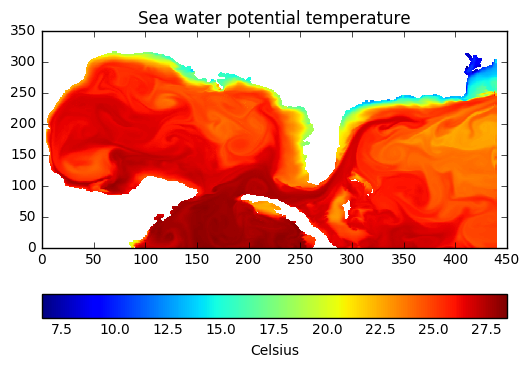

In [6]:
%matplotlib inline

import numpy.ma as ma
import iris.quickplot as qplt

T.data = ma.masked_invalid(T.data)

qplt.pcolormesh(T)

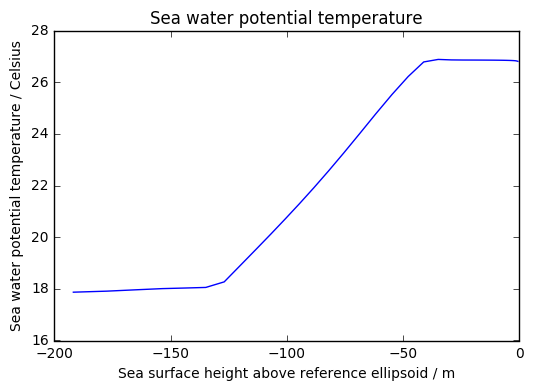

In [7]:
l = qplt.plot(t_profile)

Be aware that too much automation lead to some weird plots.

Like the `z-coord` in the `x-direction` and the automatic naming of the `z` to *Sea surface height above the reference ellipsoid* in the second plot,
or the lack of proper coordinates in the first plot.

In those cases a manual plotting is more appropriated.

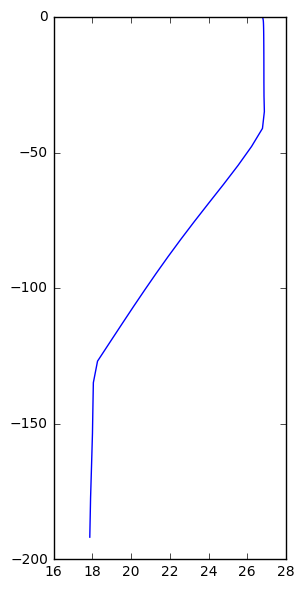

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(3, 7))

t = t_profile.data
z = t_profile.coord('sea_surface_height_above_reference_ellipsoid').points

l, = ax.plot(t, z)

### UGRID-1.0 with pyugrid

The Unstructured Grids convention encompasses any type of grid topology,
and the details of the convention are documented in http://ugrid-conventions.github.io/ugrid-conventions.
Right now `pyugrid` supports only triangular topologies, more will be added in the near future.

In a nutshell the `pyugrid` parses and exposes the underlying grid topology in a python object.

In [9]:
import pyugrid

url = 'http://crow.marine.usf.edu:8080/thredds/dodsC/FVCOM-Nowcast-Agg.nc'

ugrid = pyugrid.UGrid.from_ncfile(url)

Sometimes the topology is incomplete but,
if the data is `UGRID` compliant,
`pyugrid` can derive the rest for you.

In [10]:
ugrid.build_edges()

The topology can be extracted from `ugrid` object and used for plotting.

In [11]:
lon = ugrid.nodes[:, 0]
lat = ugrid.nodes[:, 1]
triangles = ugrid.faces[:]

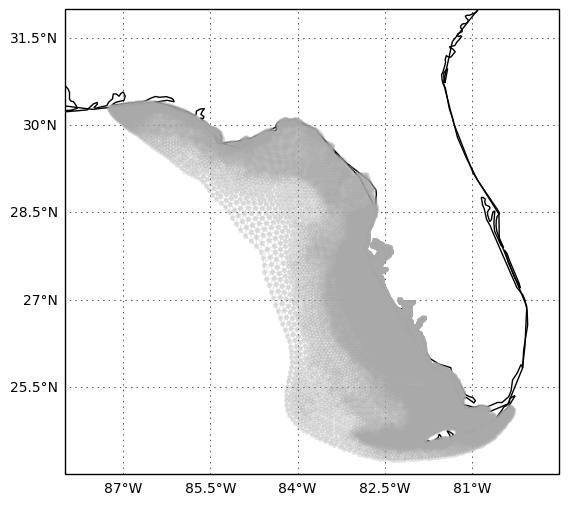

In [12]:
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


def make_map(projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(8, 6),
                           subplot_kw=dict(projection=projection))
    ax.coastlines(resolution='50m')
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

fig, ax = make_map()

kw = dict(marker='.', linestyle='-', alpha=0.25, color='darkgray')
ax.triplot(lon, lat, triangles, **kw)
ax.coastlines()
ax.set_extent([-88, -79.5, 24, 32])

There is some effort to integrate `pyugrid` into `iris` to augment the cube object to be both CF and UGRID aware.
It will add convenience plotting and slicing methods.

Check a longer `pyugrid` example [here](https://ocefpaf.github.io/python4oceanographers/blog/2015/07/20/pyugrid/).

### SGRID-0.3 with `pysgrid`

The Staggered Grid conventions help users to interpret grids from models like ROMS and DELFT,
where the variables are defined in different grids.
The specs are detailed in http://sgrid.github.io/sgrid.

The `pysgrid` module is similar to `pyugrid`. The grid topology is parsed into a Python object with methods and attributes that translate the SGRID conventions.

In [13]:
import pysgrid

url = ('http://geoport.whoi.edu/thredds/dodsC/'
       'coawst_4/use/fmrc/coawst_4_use_best.ncd')

sgrid = pysgrid.load_grid(url)

All the raw grid information is present, like edges,
dimensions, padding, and grid center, and slicing.

In [14]:
sgrid.edge1_coordinates, sgrid.edge1_dimensions, sgrid.edge1_padding

(('lon_u', 'lat_u'),
 'xi_u: xi_psi eta_u: eta_psi (padding: both)',
 [GridPadding(mesh_topology_var='grid', face_dim='eta_u', node_dim='eta_psi', padding='both')])

In [15]:
u_var = sgrid.u

u_var.center_axis, u_var.node_axis

(1, 0)

In [16]:
v_var = sgrid.v
v_var.center_axis, v_var.node_axis

(0, 1)

In [17]:
u_var.center_slicing, v_var.center_slicing

((slice(None, None, None),
  slice(None, None, None),
  slice(1, -1, None),
  slice(None, None, None)),
 (slice(None, None, None),
  slice(None, None, None),
  slice(None, None, None),
  slice(1, -1, None)))

The API is "raw" but comprehensive.
There is plenty of room to create convenience methods using the low level access provided by the library.

See below an example of the API and some simple convenience methods to `slice`, `pad`, `average`, and `rotate` the structure grid for plotting.

In [18]:
from netCDF4 import Dataset

nc = Dataset(url)
u_velocity = nc.variables[u_var.variable]
v_velocity = nc.variables[v_var.variable]

v_idx = 0  # Bottom.
time_idx = -1  # Last time step.

u = u_velocity[time_idx, v_idx, u_var.center_slicing[-2], u_var.center_slicing[-1]]
v = v_velocity[time_idx, v_idx, v_var.center_slicing[-2], v_var.center_slicing[-1]]

# Average at the center.
from pysgrid.processing_2d import avg_to_cell_center

u = avg_to_cell_center(u, u_var.center_axis)
v = avg_to_cell_center(v, v_var.center_axis)

# **Rotate the grid.
from pysgrid.processing_2d import rotate_vectors

angles = nc.variables[sgrid.angle.variable][sgrid.angle.center_slicing]
u, v = rotate_vectors(u, v, angles)

# Compute the speed.
from pysgrid.processing_2d import vector_sum

speed = vector_sum(u, v)

/home/filipe/miniconda3/envs/IOOS/lib/python3.5/site-packages/numpy/ma/core.py:882: RuntimeWarning: invalid value encountered in less
  return umath.less(x, self.critical_value)


\*\* CF convention do describe the angle variable for grids that needs rotation,
but there is no action expected like in the `formula_terms`.
`pysgrid` must be improved to abstract that action when needed via a simpler method.

```xml
<entry id="angle_of_rotation_from_east_to_x">
    <canonical_units>degree</canonical_units>
    <grib></grib>
    <amip></amip>
    <description>The quantity with standard name angle_of_rotation_from_east_to_x is the angle, anticlockwise reckoned positive, between due East and (dr/di)jk, where r(i,j,k) is the vector 3D position of the point with coordinate indices (i,j,k).  It could be used for rotating vector fields between model space and latitude-longitude space.</description>
</entry>
```

In [19]:
lon_var_name, lat_var_name = sgrid.face_coordinates

sg_lon = getattr(sgrid, lon_var_name)
sg_lat = getattr(sgrid, lat_var_name)

lon = sgrid.center_lon[sg_lon.center_slicing]
lat = sgrid.center_lat[sg_lat.center_slicing]

Ideally all the steps above could be performed in the background, in a high level object method call, like the `iris` cube plotting methods.

Let's subset and center the velocity for better visualization (not a mandatory step but recommended).

In [20]:
def is_monotonically_increasing(arr, axis=0):
    return np.all(np.diff(arr, axis=axis) > 0)


def is_monotonically_decreasing(arr, axis=0):
    return np.all(np.diff(arr, axis=axis) < 0)


def is_monotonic(arr):
    return (is_monotonically_increasing(arr) or
            is_monotonically_decreasing(arr))


def extent_bounds(arr, bound_position=0.5, axis=0):
    if not is_monotonic(arr):
        msg = "Array {!r} must be monotonic to guess bounds".format
        raise ValueError(msg(arr))

    x = arr.copy()
    x = np.c_[x[:, 0], (bound_position * (x[:, :-1] + x[:, 1:])), x[:, -1]]
    x = np.r_[x[0, :][None, ...], (bound_position * (x[:-1, :] + x[1:, :])), x[-1, :][None, ...]]

    return x

In [21]:
import numpy as np

sub = 10

lon = lon[::sub, ::sub]
lat = lat[::sub, ::sub]
u, v = u[::sub, ::sub], v[::sub, ::sub]
speed = speed[::sub, ::sub]

x = extent_bounds(lon)
y = extent_bounds(lat)

Now we can use quiver to plot the velocity components in a single grid. 

In [22]:
def make_map(projection=ccrs.PlateCarree(), figsize=(9, 9)):
    fig, ax = plt.subplots(figsize=figsize,
                           subplot_kw=dict(projection=projection))
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

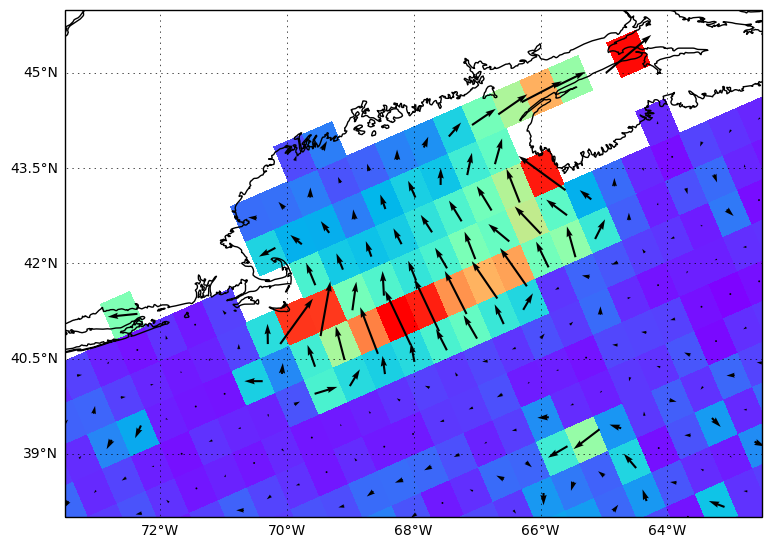

In [23]:
scale = 0.06

fig, ax = make_map()

kw = dict(scale=1.0/scale, pivot='middle', width=0.003, color='black')
q = plt.quiver(lon, lat, u, v, zorder=2, **kw)

plt.pcolormesh(x, y, speed, zorder=1, cmap=plt.cm.rainbow)

c = ax.coastlines('10m')
ax.set_extent([-73.5, -62.5, 38, 46])

For more examples on `pysgrid` check this [post]((https://ocefpaf.github.io/python4oceanographers/blog/2015/12/07/pysgrid/) out.